In [391]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_log_error
import seaborn as sns

In [372]:
submission = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
original = pd.read_csv("original.csv")

In [373]:
target = "Calories"

In [374]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [375]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [376]:
train

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...
749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [377]:
train["Sex"] = train["Sex"]=="male"
test["Sex"] = test["Sex"]=="male"
train

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,True,36,189.0,82.0,26.0,101.0,41.0,150.0
1,False,64,163.0,60.0,8.0,85.0,39.7,34.0
2,False,51,161.0,64.0,7.0,84.0,39.8,29.0
3,True,20,192.0,90.0,25.0,105.0,40.7,140.0
4,False,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...
749995,True,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,False,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,True,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,True,45,182.0,91.0,17.0,102.0,40.3,109.0


In [378]:
trainX = train.drop(target, axis=1)
trainY = train[target]

In [379]:
X_train, X_val, Y_train, Y_val = train_test_split(trainX, trainY, train_size=0.75)

In [380]:
lgbm_base = LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=10, n_jobs=-1)
lgbm_base.fit(X_train, Y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 562500, number of used features: 7
[LightGBM] [Info] Start training from score 88.329307


LGBMRegressor(max_depth=10, n_estimators=300, n_jobs=-1)

In [412]:
Y_val

233073     81.0
382361     21.0
287297     84.0
422888     12.0
460621     22.0
          ...  
472359     72.0
49502      62.0
57913     112.0
237321    141.0
258800    152.0
Name: Calories, Length: 187500, dtype: float64

In [381]:
Y_pred = lgbm_base.predict(X_val)
Y_pred = np.clip(Y_pred, a_min=0, a_max=None) # calories burned always above 0
Y_pred

array([ 83.84729755,  22.17934453,  87.37748112, ..., 113.50112573,
       145.90201866, 157.87984316], shape=(187500,))

In [416]:
residual_df = pd.DataFrame()
residual_df["actual"] = Y_val
residual_df["predicted"] = Y_pred
residual_df

,actual,predicted
233073,81.0,83.847298
382361,21.0,22.179345
287297,84.0,87.377481
422888,12.0,12.932927
460621,22.0,21.518195
...,...,...
472359,72.0,68.997560
49502,62.0,62.418795
57913,112.0,113.501126
237321,141.0,145.902019


<Axes: xlabel='predicted', ylabel='actual'>

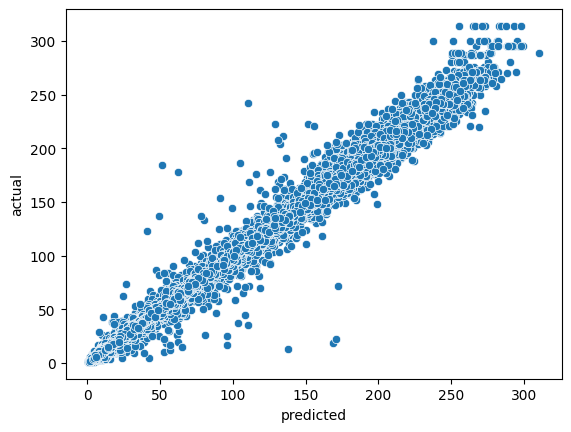

In [418]:
sns.scatterplot(residual_df, x="predicted", y="actual")

In [382]:
root_mean_squared_log_error(Y_val, Y_pred)

np.float64(0.06396661859405144)

In [383]:
lgbm_base.fit(trainX, trainY) # train on rest of the data

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 7
[LightGBM] [Info] Start training from score 88.282781


LGBMRegressor(max_depth=10, n_estimators=300, n_jobs=-1)

In [384]:
test_pred = lgbm_base.predict(test)
test_pred = np.clip(test_pred, a_min=0, a_max=None) # calories burned always above 0

In [385]:
submission[target] = test_pred
submission

,id,Calories
0,750000,27.020849
1,750001,109.154089
2,750002,87.443955
3,750003,127.475376
4,750004,74.892835
...,...,...
249995,999995,26.363539
249996,999996,9.276861
249997,999997,72.634954
249998,999998,167.337927


In [386]:
submission.to_csv("submission.csv", index=False)